# The Battle of Neighborhoods: Pandemic Friendly Metro Stations in Berlin
by Umrbek Allakulov

Pandemics, such as COVID-19, tend to spread more easily in cities. Transmission of infections is facilitated by population density and intensive use of public spaces, including public transport. In this project, which I am undertaking as part of my Applied Data Science Capstone, I will try to answer the following question: 

<i> Which metro stations in Berlin are located in neighborhoods that are convenient for living during episodes of pandemics? </i>

This notebook shows the code and data analysis, which feed into the report available in my project repository on GitHub. 


## Import necessary libraries

In [1116]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment if you don't have geopy previously installed!
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you don't have folium previsly
import folium # map rendering library

import seaborn as sb

print('Libraries imported.')

Libraries imported.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment if you don't have geopy previously installed


## Metro station dataset

The dataset on metro stations is available at https://daten.berlin.de/datensaetze/koordinaten-der-zugangsm%C3%B6glichkeiten-zu-stationen-0

It includes information on all public transport stations, including the metro, bus stations, and tram stations. The preprocessing stage involves retrieving metro stations (in Berlin there are U-Bahn stations and S-Bahn stations, which stand for underground and elevated train stations).

In [910]:
# Read in the dataset
stations = pd.read_csv("UMBW.CSV", sep = ";", encoding = 'unicode_escape')
stations.head()

,Bauwerk Name,Bauwerkselement Name,Bauwerkselement Typ,Bauwerkselement Nummer,Bauwerkselement Niveau,X-Koordinate,Y-Koordinate,Bauwerksreferenzort Nummer,Bauwerkselement Exportnummer
0,Aalemannufer (Berlin),Aalemannufer (Berlin),Bauwerk,463,NaN,"13,212685","52,573261",27205.0,900027205.0
1,Aalemannufer (Berlin),Bushaltestelle Niederneuendorfer Allee hinter ...,Zugang und ÖV,3,0.0,"13,212458","52,573577",NaN,300463003.0
2,Aalemannufer (Berlin),Bushaltestelle Niederneuendorfer Allee vor Aal...,Zugang und ÖV,4,0.0,"13,212484","52,573433",NaN,300463004.0
3,Aalemannufer (Berlin),Bushaltestelle Niederneuendorfer Allee vor Aal...,Zugang und ÖV,1,0.0,"13,212904","52,573159",NaN,300463001.0
4,Aalemannufer (Berlin),Endhaltestelle Niederneuendorfer Allee vor Aal...,Zugang und ÖV,2,0.0,"13,212810","52,572963",NaN,300463002.0


In [911]:
# Check dataset dimensions
stations.shape

(21247, 9)

In [912]:
# Retrieve U-Bahn and S-Bahn stations
stations = stations[stations["Bauwerkselement Name"].str.startswith(("U ", "S ", "S+"))]
stations.shape

(376, 9)

In [913]:
def clean_stations(df):
    """
    Cleans the metro stations dataset:
    
    Arguments: 
    df -- DataFrame containing data on the metro stations
    
    """
    #create and empty list
    newlist = []
    
    #iterate through the rows of "Bauwerk Name" column, retain the first part of the string    
    for row in list(df["Bauwerk Name"]):
        row = row.split('(')[0].strip()
        newlist.append(row)
    # Insert a column containing station names     
    df.insert(0, "Station", newlist) 
    
    # Drop duplicates in station names
    df.drop_duplicates(subset=['Station'], inplace = True)
    
    # rename columns containing geolocation information    
    df.rename(columns={"X-Koordinate": "Longitude", "Y-Koordinate" : "Latitude"}, inplace=True)
    
    # replace commas with dots
    df.replace(',','.', regex=True, inplace = True)
    
    # cast location columns as numeric
    cols = ["Latitude", "Longitude"]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    
    # select columns for "stations" dataset and drop rows containing NAs
    stations = df[["Station", "Latitude", "Longitude"]]
    stations.dropna(axis = 0, inplace = True)
      
    return stations    

In [914]:
# apply the function to clean stations dataset 
stations = clean_stations(stations)
stations.head()

C:\Users\ualla\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Station,Latitude,Longitude
9578,S Adlershof,52.435102,13.540553
9600,S Ahrensfelde Bhf,52.571564,13.566118
9625,S Altglienicke,52.407791,13.559602
9636,S Alt-Reinickendorf,52.577969,13.349747
9658,S Anhalter Bahnhof,52.504538,13.382077


## Mapping Berlin Stations

In this section, I vizualize the stations on the Berlin map. 

In [251]:
from geopy.geocoders import Nominatim

# Geograpical coordinates of Berlin
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent="Berlin")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [391]:
import folium

# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(stations['Latitude'], stations['Longitude'], stations['Station']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

## Obtaining data from Foursquary API

Please note: I am commenting out Foursquare credentials to avoid making unnecessary calls. I have saved the Foursquare dataset for use in the next sections.

In [406]:
#CLIENT_ID = '2LZFSJFGKCRNZLEV1OLJL4HPAHPB0IUMUCEVTDCC4RTDXXBO' # your Foursquare ID
#CLIENT_SECRET = 'X0HNR0XCSORLIONOP45GM3TW2OJBOYHRQB2NOK1UL4VXGQTM' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2LZFSJFGKCRNZLEV1OLJL4HPAHPB0IUMUCEVTDCC4RTDXXBO
CLIENT_SECRET:X0HNR0XCSORLIONOP45GM3TW2OJBOYHRQB2NOK1UL4VXGQTM


In [410]:
#LIMIT = 30 # limit of number of venues returned by Foursquare API
#radius = 500 # define radius

In [411]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [414]:
berlin_venues = getNearbyVenues(names=stations['Station'],
                                   latitudes=stations['Latitude'],
                                   longitudes=stations['Longitude']
                                  )

S Adlershof
S Ahrensfelde Bhf
S Altglienicke
S Alt-Reinickendorf
S Anhalter Bahnhof
S Attilastr.
S Babelsberg
S Baumschulenweg
S Bellevue
S Bergfelde
S Bernau Bhf
S Bernau-Friedenstal
S Betriebsbahnhof Rummelsburg
S Betriebsbahnhof Schöneweide
S Beusselstr.
S Biesdorf
S Birkenstein
S Birkenwerder Bhf
S Blankenburg
S Blankenfelde
S Borgsdorf
S Bornholmer Str.
S Botanischer Garten
S Buch
S Buckower Chaussee
S Charlottenburg Bhf
S Charlottenburg/Gervinusstr.
S Eichborndamm
S Eichwalde
S Erkner Bhf
S Erkner Bhf/ZOB
S Feuerbachstr.
S Flughafen Berlin-Schönefeld Bhf
S Fredersdorf
S Fredersdorf/Nordseite
S Friedenau
S Friedrichsfelde Ost
S Friedrichshagen
S Frohnau
S Gehrenseestr.
S Greifswalder Str.
S Griebnitzsee Bhf
S Grünau
S Grünbergallee
S Grunewald
S Hackescher Markt
S Halensee
S Heerstr.
S Hegermühle
S Heiligensee
S Hennigsdorf Bhf
S Hermsdorf
S Hirschgarten
S Hohen Neuendorf
S Hohenschönhausen Bhf
S Hohenzollerndamm
S Hoppegarten
S Humboldthain
S Julius-Leber-Brücke
S Karlshorst
S Ka

In [916]:
berlin_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,S Adlershof,52.435102,13.540553,Olympia Greek Food,52.433982,13.538500,Greek Restaurant
1,S Adlershof,52.435102,13.540553,Griechisches Restaurant Athen,52.434901,13.546680,Greek Restaurant
2,S Adlershof,52.435102,13.540553,Trattoria Il Mondo,52.434788,13.543176,Trattoria/Osteria
3,S Adlershof,52.435102,13.540553,Deutsche Bank Filiale,52.436346,13.544170,Bank
4,S Adlershof,52.435102,13.540553,azuma,52.433169,13.536793,Sushi Restaurant


In [918]:
berlin_venues.shape

(6840, 7)

In [418]:
# Save a copy of the Foursquare dataset, since it's easy to run out of the API call limit
berlin_venues.to_csv("berlin_venues.csv")

In [1381]:
# Load berlin_venues.csv
berlin_venues = pd.read_csv("berlin_venues.csv")

In [532]:
# Check the number of venues per station
berlin_venues.groupby("Station")["Venue"].count().sort_values(ascending=False) 

Station
S+U Potsdamer Platz Bhf          30
S+U Neukölln                     30
U Kurfürstendamm                 30
S+U Lichtenberg Bhf              30
U Kottbusser Tor                 30
U Kochstr./Checkpoint Charlie    30
U Klosterstr.                    30
U Kleistpark                     30
S+U Pankow                       30
S+U Berlin Hauptbahnhof          30
U Karl-Marx-Str.                 30
S+U Rathaus Spandau              30
S+U Rathaus Steglitz             30
S+U Schönhauser Allee            30
U Hohenzollernplatz              30
U Hermannplatz/Urbanstr.         30
U Leinestr.                      30
U Leopoldplatz                   30
S Landsberger Allee              30
S+U Hermannstr.                  30
U Mehringdamm                    30
U Mendelssohn-Bartholdy-Park     30
S+U Gesundbrunnen Bhf            30
U Mohrenstr.                     30
U Moritzplatz                    30
U Märkisches Museum              30
U Märkisches Museum/Inselstr.    30
S+U Friedrichstr. Bh

## Clustering Berlin neighborhoods

In this section, I cluster the metro stations into various categories with regards to their suitability for living in during pandemics. To do this, I first select features. Then I use the resultant dataset to fit a K-Means models with three clusters. 

### Feature selection
Two main types of venues will be useful to cluster the neighborhoods into more pandemic friendly and more risky areas. Let's check which venue categories of most popular in the dataset 

In [1281]:
# Identify the most frequent venue categories
berlin_venues.groupby("Venue Category")["Venue"].count().sort_values(ascending = False)

Venue Category
Café                             371
Supermarket                      305
Hotel                            277
Italian Restaurant               230
Bakery                           219
Coffee Shop                      195
Ice Cream Shop                   144
German Restaurant                139
Drugstore                        137
Bar                              136
Plaza                            115
Vietnamese Restaurant            109
Bus Stop                         104
Gym / Fitness Center              99
Park                              97
Light Rail Station                92
Restaurant                        91
Doner Restaurant                  87
Pizza Place                       81
Organic Grocery                   79
Asian Restaurant                  68
Cocktail Bar                      68
Clothing Store                    65
Indian Restaurant                 59
Trattoria/Osteria                 58
Burger Joint                      57
Breakfast Spot         

I have selected the following 6 venue categories that will help to cluster similar neighborhoods. I am specifically interested in identifying 1) neighborhoods that are convenient to live in under a pandemic lockdown situation (i.e. proximity to venues offering essential goods and services) and 2) neighborhoods with high concentration of venues offering non-essential goods and services, and also attract large crowds, such as tourists. 

In [1282]:
# Select features
categories = ['Supermarket', 'Organic Grocery', 'Drugstore',
              'Souvenir Shop', 'Monument / Landmark', 'Hotel']

In [1283]:
# Dataframe with the selected features
df = berlin_venues[berlin_venues["Venue Category"].isin(categories)]

In [1284]:
df.shape

(820, 7)

In [1285]:
df.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,S Ahrensfelde Bhf,52.571564,13.566118,Lidl,52.569760,13.569398,Supermarket
10,S Ahrensfelde Bhf,52.571564,13.566118,REWE,52.568852,13.568512,Supermarket
13,S Ahrensfelde Bhf,52.571564,13.566118,NORMA,52.567515,13.563774,Supermarket
24,S Anhalter Bahnhof,52.504538,13.382077,Mövenpick Hotel Berlin,52.503805,13.380370,Hotel
30,S Anhalter Bahnhof,52.504538,13.382077,Crowne Plaza Berlin Potsdamer Platz,52.501529,13.383026,Hotel


In [1288]:
# tranform the selected features into dummy variables
dummies_df = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

# bring back the station names to the dataset
dummies_df.insert(0, "Station", berlin_venues["Station"])

In [1289]:
dummies_df.head()

,Station,Drugstore,Hotel,Monument / Landmark,Organic Grocery,Souvenir Shop,Supermarket
9,S Ahrensfelde Bhf,0,0,0,0,0,1
10,S Ahrensfelde Bhf,0,0,0,0,0,1
13,S Ahrensfelde Bhf,0,0,0,0,0,1
24,S Anhalter Bahnhof,0,1,0,0,0,0
30,S Anhalter Bahnhof,0,1,0,0,0,0


In [1378]:
# Number of unique metro stations
dummies_df["Station"].nunique()

293

In [1290]:
# group by station
berlin_grouped = dummies_df.groupby('Station').sum().reset_index()
berlin_grouped.head()

,Station,Drugstore,Hotel,Monument / Landmark,Organic Grocery,Souvenir Shop,Supermarket
0,S Ahrensfelde Bhf,0,0,0,0,0,3
1,S Anhalter Bahnhof,0,5,0,0,0,0
2,S Attilastr.,0,0,0,0,0,2
3,S Babelsberg,0,0,0,0,0,2
4,S Baumschulenweg,2,0,0,0,0,2


In [1368]:
def make_table(df):
    Type = []
    Number = []
    Percent = []
    for i in df.columns:
        Type.append(i)
        n = len(df[df[i]>=1])
        Number.append(n)
        p = round(n/df.shape[0]*100, 2)
        Percent.append(p)
    table = pd.DataFrame(list(zip(Type, Number, Percent)), columns = ["Type", "Number", "Percent"]) 
    return table

In [1375]:
# Table to show the number and percent of stations that have at least one of the selected venue types
table = make_table(cluster_df).sort_values(by = "Percent", ascending = False)
table

,Type,Number,Percent
5,Supermarket,184,62.80
1,Hotel,130,44.37
0,Drugstore,110,37.54
3,Organic Grocery,72,24.57
2,Monument / Landmark,15,5.12
4,Souvenir Shop,4,1.37


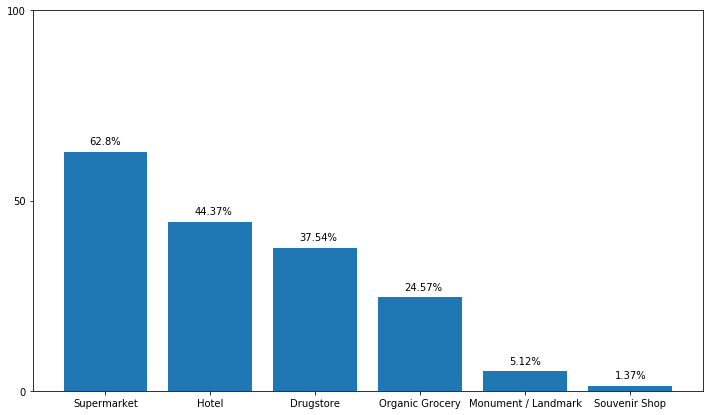

In [1377]:
# graph % of stations with with at least one of selected venue categories
plt.figure(figsize=(12,7))
plt.bar(table["Type"], table["Percent"])
plt.yticks(ticks=[0, 50, 100])
plt.ylim(0,100)
for i, v in enumerate(list(table["Percent"])):
    plt.text(i - 0.15, v + 2, str(v) + "%")

In [1291]:
# Scale the features dataset
from sklearn.preprocessing import MinMaxScaler
cluster_df = berlin_grouped.drop('Station', 1)
X = MinMaxScaler().fit_transform(cluster_df)
X

C:\Users\ualla\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.6       ],
       [0.        , 0.45454545, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.4       ],
       ...,
       [0.33333333, 0.36363636, 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.2       ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.2       ]])

In [1292]:
X.shape

(293, 6)

In [1293]:
# Run k-means to cluster the neighborhood 

# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 2, 1, 0, 0, 2, 1])

In [1296]:
# add clustering labels

berlin_grouped.insert(0, 'Cluster Labels', kmeans.labels_)


In [1297]:
berlin_grouped.head()

,Cluster Labels,Station,Drugstore,Hotel,Monument / Landmark,Organic Grocery,Souvenir Shop,Supermarket
0,0,S Ahrensfelde Bhf,0,0,0,0,0,3
1,1,S Anhalter Bahnhof,0,5,0,0,0,0
2,0,S Attilastr.,0,0,0,0,0,2
3,0,S Babelsberg,0,0,0,0,0,2
4,2,S Baumschulenweg,2,0,0,0,0,2


In [1298]:
berlin_grouped.groupby("Cluster Labels").mean()

,Drugstore,Hotel,Monument / Landmark,Organic Grocery,Souvenir Shop,Supermarket
Cluster Labels,,,,,,
0,0.000000,0.333333,0.000000,0.092593,0.009259,1.518519
1,0.311927,1.963303,0.155963,0.403670,0.027523,0.073394
2,1.355263,0.355263,0.013158,0.328947,0.000000,1.750000


In [1300]:
# To map the stations with the cluster labels, I merge the datasets that contain the locational coordinates and cluster labels
final = berlin_grouped.merge(df, how = "left", on = "Station")

In [1301]:
final.head()

,Cluster Labels,Station,Drugstore,Hotel,Monument / Landmark,Organic Grocery,Souvenir Shop,Supermarket,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,S Ahrensfelde Bhf,0,0,0,0,0,3,52.571564,13.566118,Lidl,52.569760,13.569398,Supermarket
1,0,S Ahrensfelde Bhf,0,0,0,0,0,3,52.571564,13.566118,REWE,52.568852,13.568512,Supermarket
2,0,S Ahrensfelde Bhf,0,0,0,0,0,3,52.571564,13.566118,NORMA,52.567515,13.563774,Supermarket
3,1,S Anhalter Bahnhof,0,5,0,0,0,0,52.504538,13.382077,Mövenpick Hotel Berlin,52.503805,13.380370,Hotel
4,1,S Anhalter Bahnhof,0,5,0,0,0,0,52.504538,13.382077,Crowne Plaza Berlin Potsdamer Platz,52.501529,13.383026,Hotel


### Mapping the neighborhoods

In [1304]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow = ["yellow", "red", "green"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final['Station Latitude'], final['Station Longitude'], final['Station'], final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [1382]:
#save the map as html file
map_clusters.save(outfile='map.html')

End of notebook